# CNN and RNN Examples
**Make sure you have activated the correct python envorinment**

+ Using the keras Sequential API and MNIST data

### Packages

In [7]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
np.random.seed(42)

from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Conv2D, MaxPooling2D, Flatten, SimpleRNN, LSTM
from keras.callbacks import EarlyStopping

from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

### Data

MNIST is a dataset of 60,000 28x28 grayscale images of handwritten digits, along with a test set of 10,000 images.

Load the MNIST data using keras. The first time the data are downloaded and cached.  
Subsequent times the data are loaded from the cache.

In [8]:
# load the date and split into training/testing sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

### Convert the target values vector to binary class matrix
y_train is a vector of size 60,000.  
It gets mapped to a 60,000 x 10 matrix of 0s and 1s.

In [9]:
n_classes = 10

print("Targets before: \n{}".format(y_train[:5]))
ybm_train = to_categorical(y_train, n_classes)
ybm_test = to_categorical(y_test, n_classes)
print("Targets after: \n{}".format(ybm_train[:5]))

Targets before: 
[5 0 4 1 9]
Targets after: 
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


## CNN

### Reshape and normalize the input data
The inputs are fed to the CNN as 2D images with dimensions image_size x image_size (28x28).  
The third singleton dimension is the channel, which in our case is the grayscale value.

In [10]:
image_size = x_train.shape[1]
xcnn_train = np.reshape(x_train,[-1, image_size, image_size, 1])
xcnn_test = np.reshape(x_test,[-1, image_size, image_size, 1])
xcnn_train = xcnn_train.astype('float32') / 255
xcnn_test = xcnn_test.astype('float32') / 255

Construct the CNN

In [11]:
# parameters
cnn_input_shape = (image_size, image_size, 1)
cnn1_layers = 1
kernel_size = 3
n_filters = 32
cnn1_drop_rate = 0.4

cnn1 = Sequential()
cnn1.add(Conv2D(input_shape=cnn_input_shape, filters=n_filters, kernel_size=kernel_size,  padding='same', activation='relu'))
cnn1.add(MaxPooling2D())
for i in range(cnn1_layers - 1):
    cnn1.add(Conv2D(filters=n_filters, kernel_size=kernel_size,  padding='same', activation='relu'))
    cnn1.add(Dropout(cnn1_drop_rate))
    cnn1.add(MaxPooling2D())
cnn1.add(Flatten())
cnn1.add(Dropout(cnn1_drop_rate))
cnn1.add(Dense(n_classes, activation='softmax'))
cnn1.summary()

# the number of parameters is: n_classes x (input_dim + 1)
# each node has its own bias (therefore +1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 6272)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                62730     
Total params: 63,050
Trainable params: 63,050
Non-trainable params: 0
_________________________________________________________________


### Compile and fit the model

In [18]:
# compile, fit and evaluate
cnn1.compile(optimizer='nadam', loss='categorical_crossentropy', metrics=['accuracy'])

cnn1_batch_size = 1000
cnn1_epochs = 10
cnn1_val_split = 0.1 
# create an early stopping callback
# cnn1_es = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, mode='auto', baseline=None, restore_best_weights=False)

cnn1_es = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, mode='auto', baseline=None)
cnn1_hist = cnn1.fit(xcnn_train, ybm_train, batch_size=cnn1_batch_size, epochs=cnn1_epochs, validation_split=cnn1_val_split, callbacks=[cnn1_es], verbose=1)
cnn1_val_score = cnn1.evaluate(xcnn_test, ybm_test, verbose=0)

print('{}-Layer CNN'.format(cnn1_layers))
print('------------------------')
print('Test loss score: {0:.4f}'.format(cnn1_val_score[0]))
print('Test accuracy:   {0:.4f}'.format(cnn1_val_score[1]))


Train on 54000 samples, validate on 6000 samples
Epoch 1/10
54000/54000 [==============================] - 23s 434us/step - loss: 0.7349 - acc: 0.8148 - val_loss: 0.2474 - val_acc: 0.9298
Epoch 2/10
54000/54000 [==============================] - 22s 405us/step - loss: 0.2805 - acc: 0.9183 - val_loss: 0.1721 - val_acc: 0.9537
Epoch 3/10
54000/54000 [==============================] - 22s 410us/step - loss: 0.2073 - acc: 0.9399 - val_loss: 0.1310 - val_acc: 0.9645
Epoch 4/10
54000/54000 [==============================] - 21s 398us/step - loss: 0.1642 - acc: 0.9528 - val_loss: 0.1081 - val_acc: 0.9712
Epoch 5/10
54000/54000 [==============================] - 21s 396us/step - loss: 0.1387 - acc: 0.9599 - val_loss: 0.0931 - val_acc: 0.9772
Epoch 6/10
54000/54000 [==============================] - 21s 397us/step - loss: 0.1216 - acc: 0.9649 - val_loss: 0.0854 - val_acc: 0.9778
Epoch 7/10
54000/54000 [==============================] - 21s 395us/step - loss: 0.1109 - acc: 0.9671 - val_loss: 0.0

### Some predictions

In [19]:
cnn1_pred = cnn1.predict(xcnn_test[:20])
cnn1_ypred = np.argmax(cnn1_pred, axis=1)

print('CNN predictions and true values')
display(cnn1_ypred.tolist())
display(y_test[:20].tolist())

CNN predictions and true values


[7, 2, 1, 0, 4, 1, 4, 9, 6, 9, 0, 6, 9, 0, 1, 5, 9, 7, 8, 4]

[7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4]

Predited values: [7 8 4]
True values: [7 3 4]


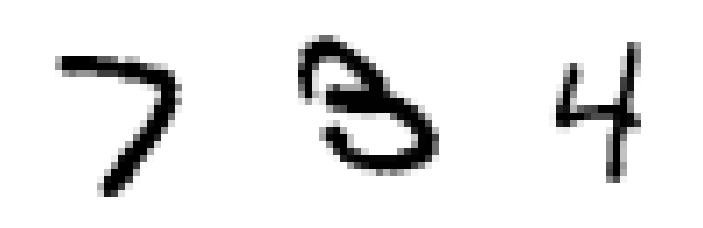

In [20]:
# plot a few digits and print the true values
idigits = [17, 18, 19]

fig = plt.figure(figsize=(12, 6))
for i in range(len(idigits)):
    ax = fig.add_subplot(1, len(idigits), i + 1)
    ax.imshow(x_test[idigits[i]], cmap = plt.cm.binary, interpolation="nearest")
    ax.axis("off")
print('Predited values: {}'.format(cnn1_ypred[idigits]))
print('True values: {}'.format(y_test[idigits]))

## RNN

### Reshape and normalize the input data
The inputs are fed to the RNN as 2D images with dimensions image_size x image_size (28x28).  
The first dimension is the 'time'.

In [21]:
xrnn_train = np.reshape(x_train,[-1, image_size, image_size])
xrnn_test = np.reshape(x_test,[-1, image_size, image_size])
xrnn_train = xrnn_train.astype('float32') / 255
xrnn_test = xrnn_test.astype('float32') / 255

### Construct a SimpleRNN

In [22]:
# parameters
rnn_input_shape = (image_size, image_size)
rnn1_layers = 1
n_units = 256
rnn1_drop_rate = 0.4

rnn1 = Sequential()
rnn1.add(SimpleRNN(input_shape=rnn_input_shape, units=n_units, activation='relu'))
rnn1.add(Dropout(rnn1_drop_rate))
for i in range(rnn1_layers - 1):
    rnn1.add(SimpleRNN(input_shape=rnn_input_shape, units=n_units, activation='relu'))
    rnn1.add(Dropout(rnn1_drop_rate))
rnn1.add(Dense(n_classes, activation='softmax'))
rnn1.summary()

# the number of parameters is: n_classes x (input_dim + 1)
# each node has its own bias (therefore +1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, 256)               72960     
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                2570      
Total params: 75,530
Trainable params: 75,530
Non-trainable params: 0
_________________________________________________________________


### Compile and fit the model

In [24]:
# compile, fit and evaluate
rnn1.compile(optimizer='nadam', loss='categorical_crossentropy', metrics=['accuracy'])

rnn1_batch_size = 1000
rnn1_epochs = 10
rnn1_val_split = 0.1 
# create an early stopping callback
# rnn1_es = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, mode='auto', baseline=None, restore_best_weights=False)

rnn1_es = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, mode='auto', baseline=None)
rnn1_hist = rnn1.fit(xrnn_train, ybm_train, batch_size=rnn1_batch_size, epochs=rnn1_epochs, validation_split=rnn1_val_split, callbacks=[rnn1_es], verbose=1)
rnn1_val_score = rnn1.evaluate(xrnn_test, ybm_test, verbose=0)

print('{}-Layer SimpleRNN'.format(rnn1_layers))
print('------------------------')
print('Test loss score: {0:.4f}'.format(rnn1_val_score[0]))
print('Test accuracy:   {0:.4f}'.format(rnn1_val_score[1]))


Train on 54000 samples, validate on 6000 samples
Epoch 1/10
54000/54000 [==============================] - 13s 247us/step - loss: 1.6807 - acc: 0.4014 - val_loss: 0.9750 - val_acc: 0.6787
Epoch 2/10
54000/54000 [==============================] - 13s 234us/step - loss: 0.8152 - acc: 0.7201 - val_loss: 0.3393 - val_acc: 0.8835
Epoch 3/10
54000/54000 [==============================] - 13s 246us/step - loss: 0.3779 - acc: 0.8804 - val_loss: 0.1826 - val_acc: 0.9437
Epoch 4/10
54000/54000 [==============================] - 13s 236us/step - loss: 0.2379 - acc: 0.9308 - val_loss: 0.1067 - val_acc: 0.9717
Epoch 5/10
54000/54000 [==============================] - 13s 239us/step - loss: 0.1750 - acc: 0.9497 - val_loss: 0.1406 - val_acc: 0.9620
Epoch 6/10
54000/54000 [==============================] - 14s 260us/step - loss: 0.1422 - acc: 0.9604 - val_loss: 2.5742 - val_acc: 0.4935
Epoch 7/10
54000/54000 [==============================] - 13s 240us/step - loss: 1.5309 - acc: 0.4893 - val_loss: 0.8

## LSTM

LSTM is a drop-in replacement for SimpleRNN

In [12]:
# parameters
rnn_input_shape = (image_size, image_size)
rnn2_layers = 1
n_units = 256
rnn2_drop_rate = 0.4

rnn2 = Sequential()
rnn2.add(LSTM(input_shape=rnn_input_shape, units=n_units, activation='relu'))
rnn2.add(Dropout(rnn2_drop_rate))
for i in range(rnn2_layers - 1):
    rnn2.add(SimpleRNN(input_shape=rnn_input_shape, units=n_units, activation='relu'))
    rnn2.add(Dropout(rnn2_drop_rate))
rnn2.add(Dense(n_classes, activation='softmax'))
rnn2.summary()

# the number of parameters is: n_classes x (input_dim + 1)
# each node has its own bias (therefore +1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 256)               291840    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                2570      
Total params: 294,410
Trainable params: 294,410
Non-trainable params: 0
_________________________________________________________________


In [13]:
# compile, fit and evaluate
rnn2.compile(optimizer='nadam', loss='categorical_crossentropy', metrics=['accuracy'])

rnn2_batch_size = 1000
rnn2_epochs = 10
rnn2_val_split = 0.1 
# create an early stopping callback
rnn2_es = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, mode='auto', baseline=None, restore_best_weights=False)

rnn2_hist = rnn2.fit(xrnn_train, ybm_train, batch_size=rnn2_batch_size, epochs=rnn2_epochs, validation_split=rnn2_val_split, callbacks=[rnn2_es], verbose=1)
rnn2_val_score = rnn2.evaluate(xrnn_test, ybm_test, verbose=0)

print('{}-Layer LSTM'.format(rnn2_layers))
print('------------------------')
print('Test loss score: {0:.4f}'.format(rnn2_val_score[0]))
print('Test accuracy:   {0:.4f}'.format(rnn2_val_score[1]))

Train on 54000 samples, validate on 6000 samples
Epoch 1/10
54000/54000 [==============================] - 70s 1ms/step - loss: 2.1541 - acc: 0.3024 - val_loss: 1.7647 - val_acc: 0.3960
Epoch 2/10
54000/54000 [==============================] - 65s 1ms/step - loss: 1.5826 - acc: 0.4680 - val_loss: 0.8452 - val_acc: 0.7092
Epoch 3/10
54000/54000 [==============================] - 69s 1ms/step - loss: 1.0846 - acc: 0.6247 - val_loss: 0.5174 - val_acc: 0.8167
Epoch 4/10
54000/54000 [==============================] - 70s 1ms/step - loss: 0.4640 - acc: 0.8443 - val_loss: 0.3413 - val_acc: 0.8755
Epoch 5/10
54000/54000 [==============================] - 66s 1ms/step - loss: 0.2889 - acc: 0.9078 - val_loss: 0.1430 - val_acc: 0.9540
Epoch 6/10
54000/54000 [==============================] - 69s 1ms/step - loss: 0.1937 - acc: 0.9393 - val_loss: 0.1139 - val_acc: 0.9623
Epoch 7/10
54000/54000 [==============================] - 67s 1ms/step - loss: 0.1586 - acc: 0.9517 - val_loss: 0.0866 - val_acc: